<a href="https://colab.research.google.com/github/anspire/Notebooks/blob/master/Image_restoration_using_GAN_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Restoration using GAN

**Image Restoration** is the operation of taking a corrupt/noisy image and estimating the clean, original image.

#Setup

## Intended Structure after Setup

Run the blocks in this section to get the following directory structure:
```
/content
│
└───rephrase-pubfig831
    │
    └───correct
    │   │
    │   └───train
    │   │   │
    │   │   └───Adam Sandler
    │   │   │   │   train__000001-000000.jpg
    │   │   │   │   train__000001-000001.jpg
    │   │   │   │   train__000001-000002.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Alec Baldwin
    │   │   │   │   train__000002-000000.jpg
    │   │   │   │   train__000002-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   └───Angelina Jolie
    │   │   │   │   train__000003-000000.jpg
    │   │   │   │   train__000003-000001.jpg
    │   │   │   │   ...
    │   │   │
    │   │   │ ...
    │   │
    │   └───test
    │       │
    │       └───Adam Sandler
    │       │   │   test__000001-000000.jpg
    │       │   │   test__000001-000001.jpg
    │       │   │   ...
    │       │
    │       └───Alec Baldwin
    │       │   │   test__000002-000000.jpg
    │       │   │   ...
    │       │
    │       └───Angelina Jolie
    │       │   │   test__000003-000000.jpg
    │       │   │   ...
    │       │
    │       │ ...
    │
    │
    └───degraded
        │   <Same directory structure as 'correct'>
```

Every image in the degraded directory is a degraded version of the image with the same name in the correct directory. e.g. `/content/rephrase-pubfig831/degraded/Adam Sandler/train__000001-000002.jpg` is the degraded version of `/content/rephrase-pubfig831/correct/Adam Sandler/train__000001-000002.jpg`

## Installation (pip etc)


In [1]:
!pip install GPUtil
!pip install tqdm
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=96580a4f4a2d2ecc50820fbd24e800098003dd6d0a42a018e41a45de87dd4493
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


## Downloading and Generating Dataset
Run this block only once. Do not modify it. Also, don't call the degrade function in your code anywhere. You should treat the degradation process as a black box.

In [2]:
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm

def degrade(path: str) -> None:
    """Load image at `input_path`, distort and save as `output_path`"""
    SHIFT = 2
    image = cv2.imread(path)
    to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
    swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
    swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
    image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
    image[swap_indices] = swap_vals
    cv2.imwrite(path, image)

!wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
!unzip -q pubfig83lfw_raw_in_dirs.zip
!rm pubfig83lfw_raw_in_dirs.zip
!mkdir rephrase-pubfig831
!mv pubfig83lfw_raw_in_dirs rephrase-pubfig831/correct
!rm -r rephrase-pubfig831/correct/distract
!cp -r rephrase-pubfig831/correct rephrase-pubfig831/degraded

for image_path in tqdm(glob('rephrase-pubfig831/degraded/*/*/*.jpg')):
  degrade(image_path)

--2019-11-07 09:39:53--  http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
Resolving briancbecker.com (briancbecker.com)... 162.241.216.158
Connecting to briancbecker.com (briancbecker.com)|162.241.216.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400247922 (382M) [application/zip]
Saving to: ‘pubfig83lfw_raw_in_dirs.zip’

pubfig83lfw_raw_in_ 100%[===================>] 381.71M  72.8MB/s    in 5.4s    

2019-11-07 09:39:59 (70.4 MB/s) - ‘pubfig83lfw_raw_in_dirs.zip’ saved [400247922/400247922]



100%|██████████| 13002/13002 [00:59<00:00, 219.40it/s]


# **Checking Free Memory**
This block is just so that you can have an idea of the resources you have at hand on the Google Collab system.

In [3]:
import psutil
import humanize
import os
import GPUtil as GPU
gpu = GPU.getGPUs()[0]
process = psutil.Process(os.getpid())
print(f"Gen RAM: Free {humanize.naturalsize(psutil.virtual_memory().available)} | Proc size {humanize.naturalsize(process.memory_info().rss)}")
print(f"GPU RAM: Free {gpu.memoryFree:.0f}MB | Used {gpu.memoryUsed:.0f}MB | Util {gpu.memoryUtil*100:.0f}% | Total {gpu.memoryTotal:.0f}MB")

Gen RAM: Free 26.4 GB | Proc size 175.8 MB
GPU RAM: Free 11441MB | Used 0MB | Util 0% | Total 11441MB


# **Main Code**

## Imports

In [4]:
%matplotlib inline

import os
import cv2
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from os.path import isfile, join, exists

import keras.backend as K
from keras.optimizers import Adam
from keras.applications.vgg19 import VGG19
from keras.models import Sequential, Model, load_model
from keras.layers import BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, add
from keras.layers.convolutional import Conv2D, Conv2DTranspose, UpSampling2D

Using TensorFlow backend.


## Constants and Hyperparemeters

In [0]:
dataset_path = 'rephrase-pubfig831'
model_path = '/content'
image_shape = (256,256,3)

## Data Loader

In [0]:
def load_data(path, image_shape, train = True):
  path = join(path, 'degraded')
  if train:
    path = join(path, 'train')
  else:
    path = join(path, 'test')
  dirs = os.listdir(path)
  fpaths = []
  for root, dirs, files in os.walk(path):
    for file in files:
      fpaths.append(join(root, file))
  X = []
  Y = []
  w, h, _ = image_shape
  for f_name in fpaths:
    x = cv2.imread(f_name)
    y = cv2.imread(f_name.replace('degraded', 'correct'))

    x = cv2.resize(x, (w, h), interpolation=cv2.INTER_LINEAR)
    y = cv2.resize(y, (w, h), interpolation=cv2.INTER_LINEAR)

    X.append(x)
    Y.append(y)
  
  X = (np.asarray(X).astype(np.float32) - 127.5)/127.5 
  Y = (np.asarray(Y).astype(np.float32) - 127.5)/127.5 
  
  return X, Y

In [7]:
X_train, Y_train = load_data(dataset_path, image_shape, train = True)
print('Number of Training examples :', X_train.shape[0])

#X_test, Y_test = load_data(dataset_path, image_shape, train = False)
#print('Number of Training examples :', X_test.shape[0])

Number of Training examples : 8720


## Models

### Generator Model

In [0]:
class Generator(object):
  
  def __init__(self, input_shape):
    self.input_shape = input_shape

  def res_block(self, x, kernal_size, filters, strides):
    gen = x
    
    x = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)
    x = Conv2D(filters = filters, kernel_size = kernal_size, strides = strides, padding = "same")(x)
    x = BatchNormalization(momentum = 0.5)(x)
    
    return add([gen, x])

  def generator(self):
    gen_input = Input(shape = self.input_shape)
    x = Conv2D(filters = 64, kernel_size = 9, strides = 1, padding = "same")(gen_input)
    x = LeakyReLU(alpha=0.2)(x)
    gen = x

    for index in range(8):
	    x = self.res_block(x, 3, 64, 1)

    x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = add([gen, x])
	
    x = Conv2DTranspose(filters = 32, kernel_size = 3, strides = 1, padding = "same")(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Conv2DTranspose(filters = 16, kernel_size = 3, strides = 1, padding = "same")(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Conv2D(filters = 3, kernel_size = 9, strides = 1, padding = "same")(x)
    x = Activation('tanh')(x)
	   
    return Model(inputs = gen_input, outputs = x)

In [9]:
generator = Generator(image_shape).generator()
generator.summary()












Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 15616       input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 256, 256, 64) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       leaky_re_lu_1[0][0]              
_________________________________________________________________________________

### Discriminator Model

In [0]:
class Discriminator(object):

  def __init__(self, input_shape):
    self.input_shape = input_shape

  def discriminator_block(self, x, filters, kernel_size, strides):
    x = Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = "same")(x)
    x = BatchNormalization(momentum = 0.5)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    
    return x

  def discriminator(self):
    dis_input = Input(shape = self.input_shape)
    x = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
    x = LeakyReLU(alpha = 0.2)(x)
    
    x = self.discriminator_block(x, 64, 3, 2)
    x = self.discriminator_block(x, 128, 3, 1)
    x = self.discriminator_block(x, 128, 3, 2)
    x = self.discriminator_block(x, 256, 3, 1)
    x = self.discriminator_block(x, 256, 3, 2)
    x = self.discriminator_block(x, 512, 3, 1)
    x = self.discriminator_block(x, 512, 3, 2)
    
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha = 0.2)(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x) 
    
    return Model(inputs = dis_input, outputs = x)

In [11]:
discriminator = Discriminator(image_shape).discriminator()
discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_18 (Batc (None, 128, 128, 64)      256       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 128)     7385

### GAN Model

In [0]:
class GAN(object):

  def __init__(self, input_shape, generator, discriminator):
    self.input_shape = input_shape
    self.generator = generator
    self.discriminator = discriminator

  def gan(self):
    self.discriminator.trainable = False
    
    gan_input = Input(shape= self.input_shape)
    generator_out = self.generator(gan_input)
    discriminator_out = self.discriminator(generator_out)

    return Model(inputs = gan_input, outputs = [generator_out, discriminator_out])  

In [13]:
gan = GAN(image_shape, generator, discriminator).gan()
gan.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
model_1 (Model)              (None, 256, 256, 3)       675235    
_________________________________________________________________
model_2 (Model)              (None, 1)                 138912577 
Total params: 139,587,812
Trainable params: 673,059
Non-trainable params: 138,914,753
_________________________________________________________________


## Loss Functions

In [0]:
def vgg_loss(y_true, y_pred):
  vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=image_shape)
  vgg19.trainable = False
  for l in vgg19.layers:
    l.trainable = False
  loss_model = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block5_conv4').output)
  loss_model.trainable = False
  
  return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))

loss = vgg_loss

## Optimizer

In [0]:
optimizer = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

## Training

In [0]:
def train(X_train, Y_train, generator, discriminator, gan, epochs= 5, batch_size= 16):
  batch_count = int(X_train.shape[0] / batch_size)

  #valid = np.ones((batch_size, 1))
  #fake = np.zeros((batch_size, 1))

  for e in range(1, epochs+1):
    print ('-'*15, 'Epoch %d' % e, '-'*15)
    d_loss = 0
    g_loss = 0
    for _ in range(batch_count): 
      idx = np.random.randint(0, X_train.shape[0], batch_size)  
      x = X_train[idx]
      y = Y_train[idx]

      generated_images = generator.predict(x)

      valid = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
      fake = np.random.random_sample(batch_size)*0.2

      discriminator.trainable = True  
      d_loss_real = discriminator.train_on_batch(y, valid)
      d_loss_fake = discriminator.train_on_batch(generated_images, fake)
      d_loss += 0.5 * np.add(d_loss_fake, d_loss_real)

      idx = np.random.randint(0, X_train.shape[0], batch_size)  
      x = X_train[idx]
      y = Y_train[idx]

      valid = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2

      discriminator.trainable = False
      loss = gan.train_on_batch(x,[y, valid])
      g_loss += loss[0]
            
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (e, d_loss[0]/batch_count, 100*(d_loss[1]/batch_count), g_loss/batch_count))
    plot_generated_images(generator, num = 5)
    if e % 5 == 0:
      generator.save_weights(join(model_path, 'gen_weigths.h5'))
      discriminator.save_weights(join(model_path, 'dis_weigths.h5'))
      gan.save_weights(join(model_path, 'gan_weigths.h5'))

In [17]:
## compile Generator
generator.compile(loss= vgg_loss, optimizer= optimizer)

## compile Discriminator
discriminator.compile(loss="binary_crossentropy", optimizer= optimizer, metrics= ['accuracy'])

## compile GAN 
gan.compile(loss=[ vgg_loss, "binary_crossentropy"], loss_weights=[1., 1e-3], optimizer=optimizer)

## Load weigths
if exists(join(model_path, 'gen_weigths.h5')):
  generator.load_weights(join(model_path, 'gen_weigths.h5'))
if exists(join(model_path, 'dis_weigths.h5')):
  discriminator.load_weights(join(model_path, 'dis_weigths.h5'))
if exists(join(model_path, 'gan_weigths.h5')):
  combined.load_weights(join(model_path, 'gan_weigths.h5'))



80142336/80134624 [==============================] - 1s 0us/step

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


--------------- Epoch 1 ---------------


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 [D loss: 0.929897, acc.: 0.00%] [G loss: 0.001898]


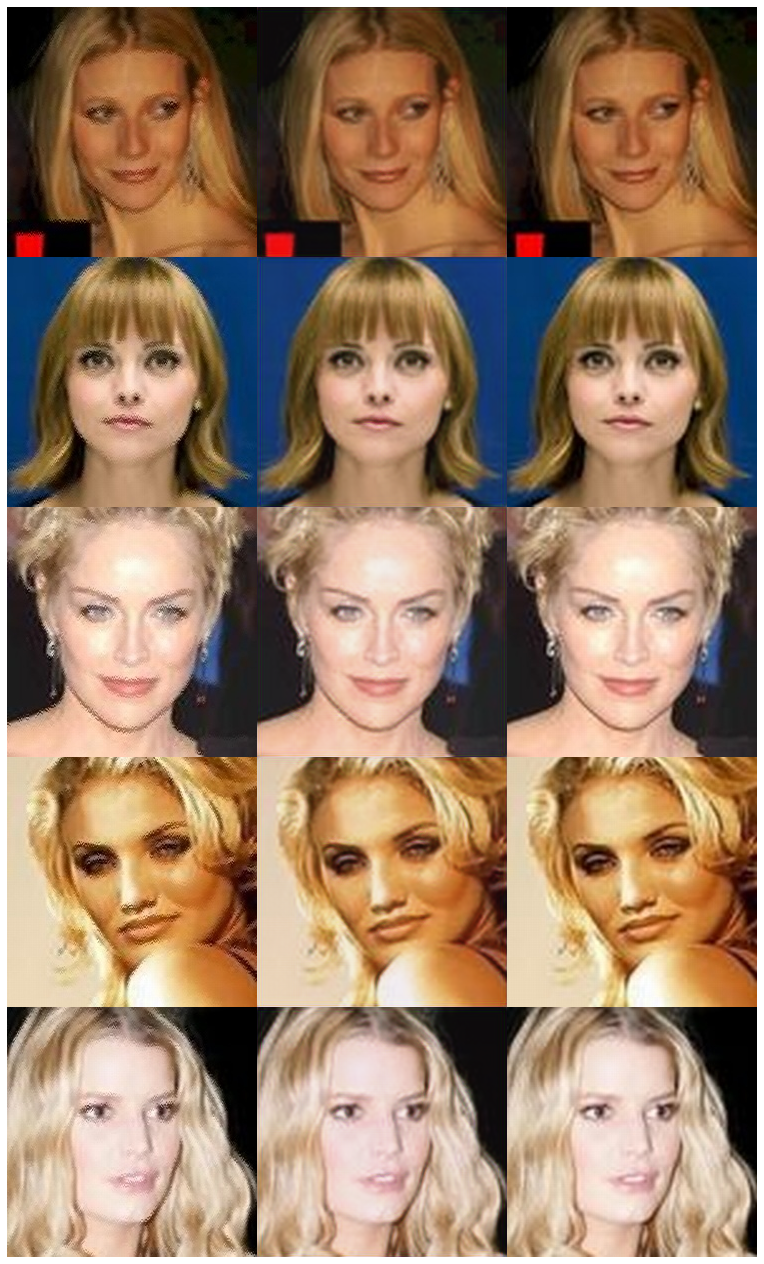

--------------- Epoch 2 ---------------
2 [D loss: 0.949602, acc.: 0.00%] [G loss: 0.001629]


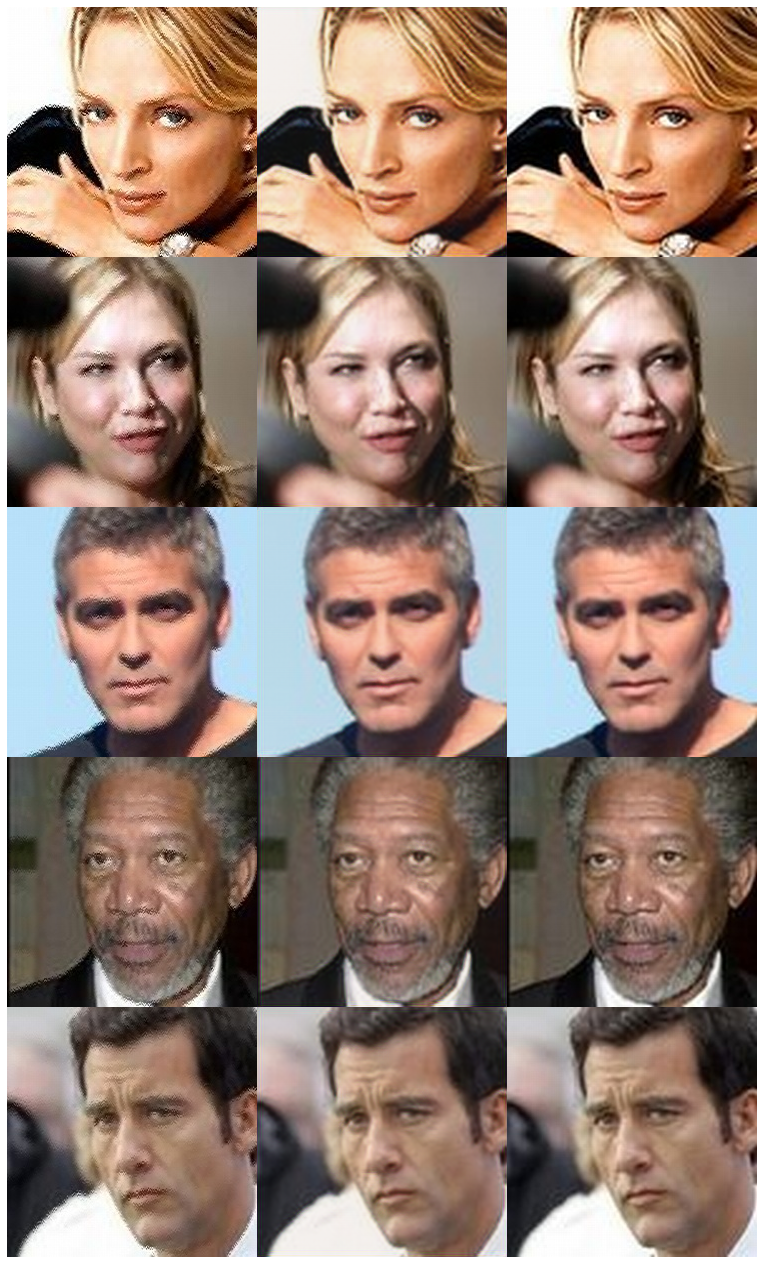

--------------- Epoch 3 ---------------
3 [D loss: 0.971049, acc.: 0.00%] [G loss: 0.001471]


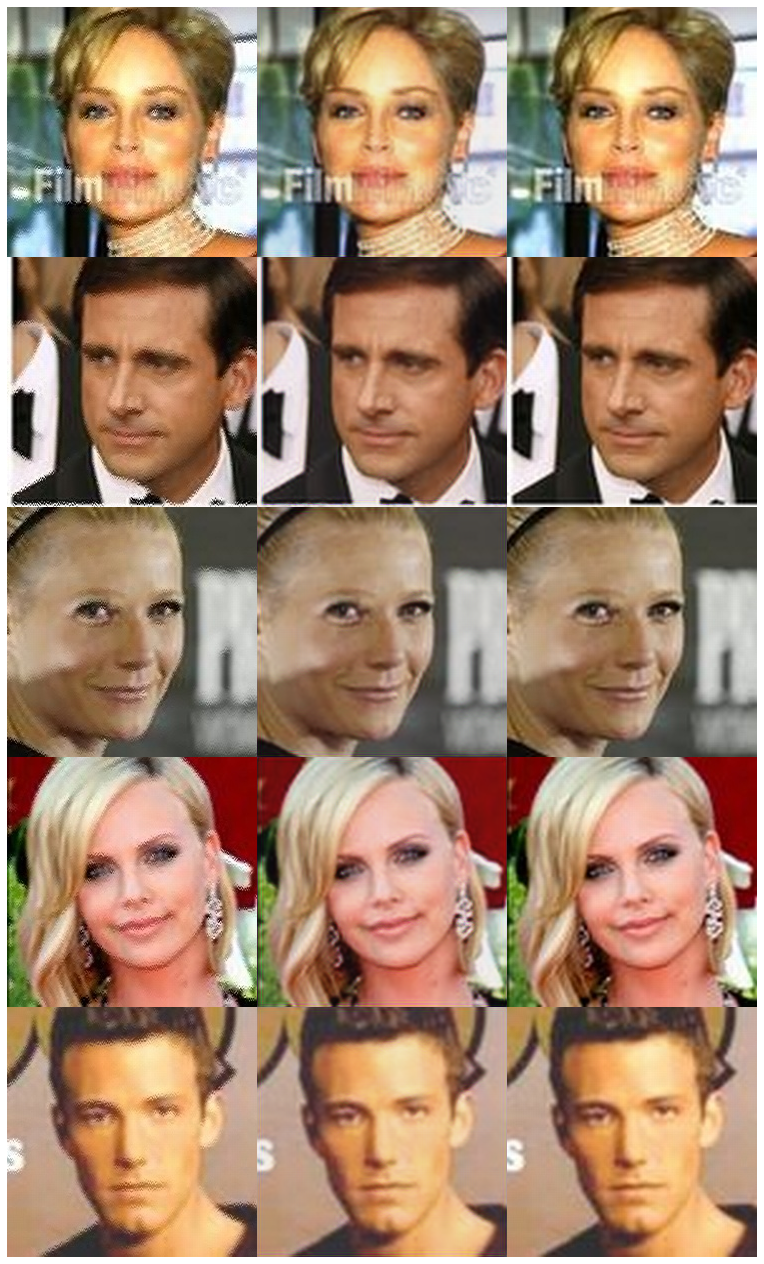

--------------- Epoch 4 ---------------


In [0]:
## Train
train(X_train, Y_train, generator, discriminator, gan, epochs= 5, batch_size= 4)

## Save Models

In [0]:
generator.save(join(model_path, 'generator_model.h5'))
discriminator.save(join(model_path, 'discriminator_model.h5'))
gan.save(join(model_path, 'gan_model.h5'))

## Evaluation

In [0]:
def plot_generated_images(generator, num = 5):
  files = glob('/content/rephrase-pubfig831/correct/test/*/*')
  grid = []

  for path in random.sample(files, num):
    correct = cv2.imread(path)
    split = path.split('/')

    degraded = cv2.imread('/'.join([*split[:3], 'degraded', *split[4:]]))
    im = degraded
    im = cv2.resize(im,(image_shape[0],image_shape[1]),interpolation=cv2.INTER_LINEAR)
    im = np.expand_dims(im, axis=0)
    im = (im.astype(np.float32) - 127.5)/127.5 

    gen_img = generator.predict(im)
    gen_img = (gen_img + 1) * 127.5
    gen_img = cv2.resize(gen_img[0].astype(np.uint8) ,(250,250),interpolation=cv2.INTER_AREA)
    grid.append(np.column_stack([degraded, gen_img, correct]))

  image = np.row_stack(grid)
  dpi = float(plt.rcParams['figure.dpi'])
  figsize = image.shape[1] / dpi, image.shape[0] / dpi
  ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
  ax.axis('off')
  ax.imshow(image[..., ::-1])
  plt.show()

In [0]:
plot_generated_images(generator)